In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Connect to the Data Warehouse (Created by our Pipeline)
conn = sqlite3.connect('../database/supply_chain_dw.db')

In [3]:
# Query: Join Fact and Dimension tables for analysis
query = """
SELECT 
    f.days_scheduled,
    f.shipping_mode,
    f.benefit_per_order,
    f.late_delivery_risk,
    l.market,
    l.order_region,
    p.category_name
FROM fact_orders f
JOIN dim_location l ON f.location_id = l.location_id
JOIN dim_products p ON f.product_card_id = p.product_card_id
"""

df = pd.read_sql(query, conn)
df.head()

,days_scheduled,shipping_mode,benefit_per_order,late_delivery_risk,market,order_region,category_name
0,4,Standard Class,88.790001,0,LATAM,Central America,Camping & Hiking
1,4,Standard Class,91.180000,0,LATAM,South America,Water Sports
2,4,Standard Class,68.250000,0,LATAM,South America,Women's Apparel
3,4,Standard Class,36.470001,0,LATAM,South America,Men's Footwear
4,4,Standard Class,4.100000,1,LATAM,South America,Accessories


In [4]:
# Convert Categorical columns to numeric codes
df['shipping_mode_code'] = df['shipping_mode'].astype('category').cat.codes
df['market_code'] = df['market'].astype('category').cat.codes
df['category_code'] = df['category_name'].astype('category').cat.codes

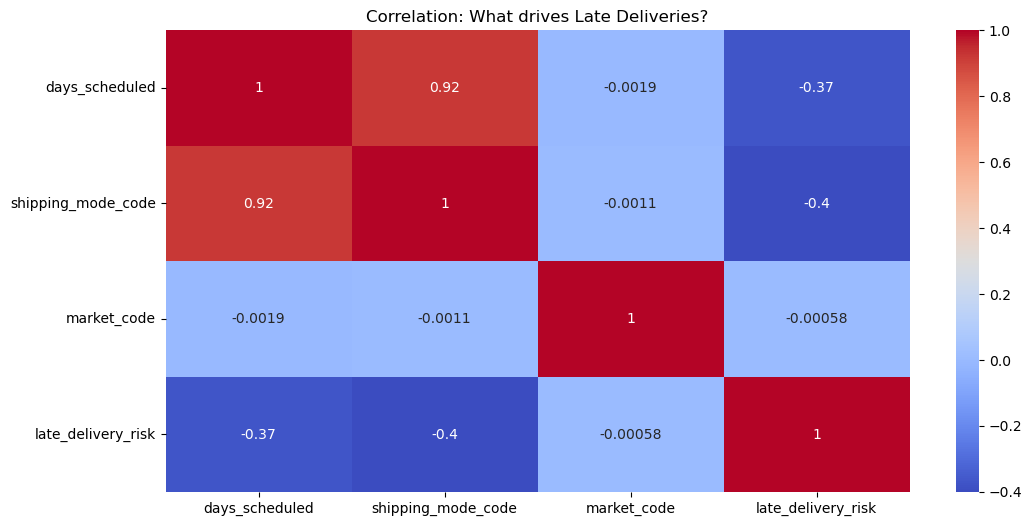

In [5]:
# Check correlations
plt.figure(figsize=(12,6))
sns.heatmap(df[['days_scheduled', 'shipping_mode_code', 'market_code', 'late_delivery_risk']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation: What drives Late Deliveries?")
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Features (X) and Target (y)
# We want to predict 'late_delivery_risk' (0 or 1)
feature_cols = ['shipping_mode_code', 'days_scheduled', 'market_code', 'category_code']
X = df[feature_cols]
y = df['late_delivery_risk']

# Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.87      0.72     16273
           1       0.83      0.55      0.66     19831

    accuracy                           0.69     36104
   macro avg       0.72      0.71      0.69     36104
weighted avg       0.73      0.69      0.69     36104



In [7]:
# Feature Importance
import numpy as np
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Ranking:")
for f in range(X.shape[1]):
    print(f"{f+1}. {feature_cols[indices[f]]} ({importances[indices[f]]:.4f})")



Feature Ranking:
1. days_scheduled (0.5045)
2. shipping_mode_code (0.4684)
3. category_code (0.0231)
4. market_code (0.0040)


## Insight: 

Shipping Mode is the strongest predictor. If a customer chooses 'Standard Class', the risk of delay increases significantly.

Recommendation: Offer incentives for 'Same Day' shipping on high-value orders to reduce delay risk.